# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

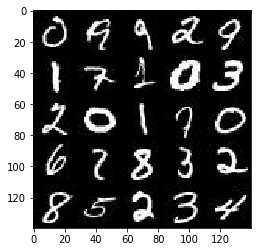

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

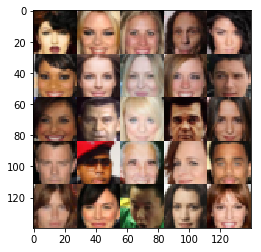

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_ = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim))
    lr = tf.placeholder(dtype=tf.float32, shape=None)
    return input_, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28
        conv1 = tf.layers.conv2d(inputs=images, filters=32, kernel_size=5, strides=2, activation=None)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 14*14
        
        conv2 = tf.layers.conv2d(inputs=conv1, filters=128, kernel_size=5, strides=2, activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=True)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 7*7

        flat = tf.reshape(conv2, (-1, 4*4*256))
        logits = tf.layers.dense(inputs=flat, units=1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        fc = tf.layers.dense(inputs=z, units=7*7*256, activation=None)
        conv1 = tf.reshape(fc, shape=(-1, 7, 7, 256))
        conv1 = tf.layers.batch_normalization(inputs=conv1, training=is_train)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 7*7
        
        conv2 = tf.layers.conv2d_transpose(inputs=conv1, filters=128, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=is_train)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 14*14
        
        # Output layer, 28*28
        logits = tf.layers.conv2d_transpose(inputs=conv2, filters=out_channel_dim, kernel_size=5, strides=2, padding='SAME', activation=None)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    show_every = 50
    print_every = 10
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        losses = []
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 4, input_z, len(data_image_mode), data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5229... Generator Loss: 0.9506
Epoch 1/2... Discriminator Loss: 0.4455... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 0.2254... Generator Loss: 1.6511
Epoch 1/2... Discriminator Loss: 0.1333... Generator Loss: 2.1095
Epoch 1/2... Discriminator Loss: 0.0595... Generator Loss: 2.9616


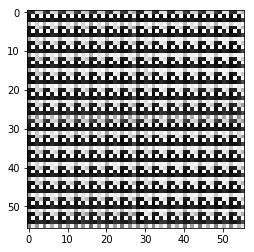

Epoch 1/2... Discriminator Loss: 0.0342... Generator Loss: 3.4226
Epoch 1/2... Discriminator Loss: 0.0200... Generator Loss: 3.9678
Epoch 1/2... Discriminator Loss: 0.0172... Generator Loss: 4.1302
Epoch 1/2... Discriminator Loss: 0.0121... Generator Loss: 4.5092
Epoch 1/2... Discriminator Loss: 0.0100... Generator Loss: 4.7334


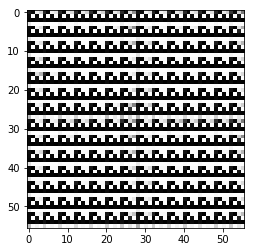

Epoch 1/2... Discriminator Loss: 0.0073... Generator Loss: 5.0102
Epoch 1/2... Discriminator Loss: 0.0064... Generator Loss: 5.1953
Epoch 1/2... Discriminator Loss: 0.0056... Generator Loss: 5.3721
Epoch 1/2... Discriminator Loss: 0.0044... Generator Loss: 5.5424
Epoch 1/2... Discriminator Loss: 0.0035... Generator Loss: 5.6803


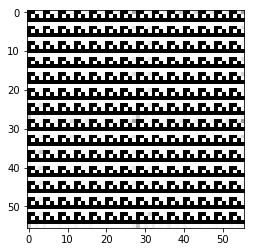

Epoch 1/2... Discriminator Loss: 0.0035... Generator Loss: 5.7391
Epoch 1/2... Discriminator Loss: 0.0032... Generator Loss: 5.7612
Epoch 1/2... Discriminator Loss: 0.0030... Generator Loss: 5.8921
Epoch 1/2... Discriminator Loss: 0.0023... Generator Loss: 6.1536
Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 6.2820


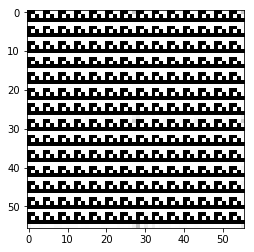

Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 6.3704
Epoch 1/2... Discriminator Loss: 0.0018... Generator Loss: 6.4597
Epoch 1/2... Discriminator Loss: 0.0016... Generator Loss: 6.5156
Epoch 1/2... Discriminator Loss: 0.0019... Generator Loss: 6.4039
Epoch 1/2... Discriminator Loss: 0.0016... Generator Loss: 6.5417


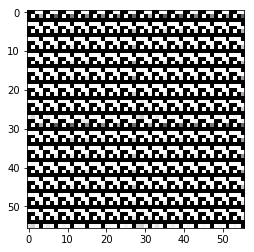

Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 6.6507
Epoch 1/2... Discriminator Loss: 0.0013... Generator Loss: 6.8756
Epoch 1/2... Discriminator Loss: 0.0022... Generator Loss: 6.2776
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 7.1008
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 6.8228


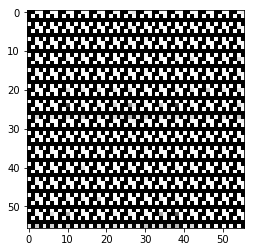

Epoch 1/2... Discriminator Loss: 0.0019... Generator Loss: 6.4753
Epoch 1/2... Discriminator Loss: 0.0018... Generator Loss: 6.4831
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 6.6926
Epoch 1/2... Discriminator Loss: 0.0013... Generator Loss: 6.7914
Epoch 1/2... Discriminator Loss: 0.0013... Generator Loss: 6.7424


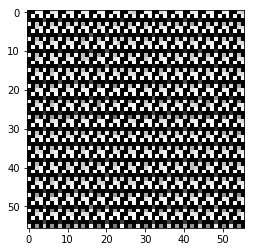

Epoch 1/2... Discriminator Loss: 0.0013... Generator Loss: 6.7887
Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 6.5739
Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 7.1604
Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 7.0958
Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 7.3002


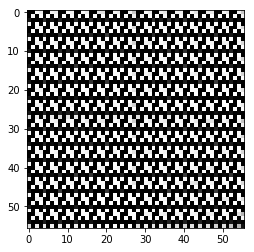

Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 6.9925
Epoch 1/2... Discriminator Loss: 0.0025... Generator Loss: 6.0221
Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 6.5613
Epoch 1/2... Discriminator Loss: 0.0023... Generator Loss: 6.1169
Epoch 1/2... Discriminator Loss: 0.0033... Generator Loss: 5.8611


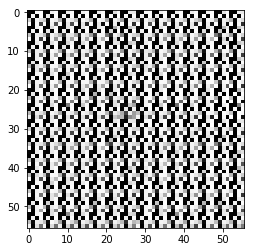

Epoch 1/2... Discriminator Loss: 0.0022... Generator Loss: 6.2536
Epoch 1/2... Discriminator Loss: 0.0028... Generator Loss: 6.0708
Epoch 1/2... Discriminator Loss: 0.0044... Generator Loss: 5.5687
Epoch 1/2... Discriminator Loss: 0.0049... Generator Loss: 5.4633
Epoch 1/2... Discriminator Loss: 0.0031... Generator Loss: 5.8226


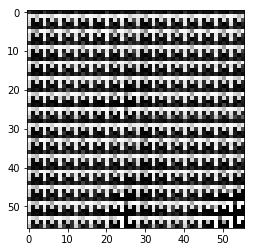

Epoch 1/2... Discriminator Loss: 6.5438... Generator Loss: 0.2073
Epoch 1/2... Discriminator Loss: 0.5375... Generator Loss: 1.3235
Epoch 1/2... Discriminator Loss: 0.0132... Generator Loss: 5.3263
Epoch 1/2... Discriminator Loss: 0.0175... Generator Loss: 5.4133
Epoch 1/2... Discriminator Loss: 0.0031... Generator Loss: 5.9644


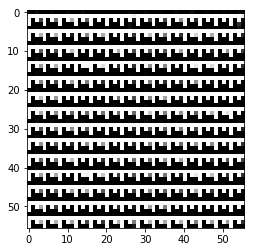

Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 30.9804
Epoch 1/2... Discriminator Loss: 0.0205... Generator Loss: 16.9969
Epoch 1/2... Discriminator Loss: 7.1908... Generator Loss: 0.0343
Epoch 1/2... Discriminator Loss: 2.9713... Generator Loss: 0.1876
Epoch 1/2... Discriminator Loss: 0.4552... Generator Loss: 3.0833


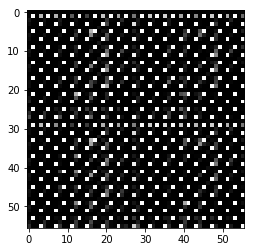

Epoch 1/2... Discriminator Loss: 0.0071... Generator Loss: 11.3164
Epoch 1/2... Discriminator Loss: 2.6354... Generator Loss: 0.2358
Epoch 1/2... Discriminator Loss: 0.3773... Generator Loss: 1.5434
Epoch 1/2... Discriminator Loss: 1.4495... Generator Loss: 1.0014
Epoch 1/2... Discriminator Loss: 0.7075... Generator Loss: 2.8194


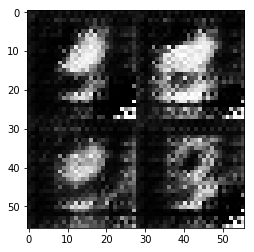

Epoch 1/2... Discriminator Loss: 3.6148... Generator Loss: 0.3355
Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 0.6115
Epoch 1/2... Discriminator Loss: 3.3945... Generator Loss: 0.0480
Epoch 1/2... Discriminator Loss: 3.4871... Generator Loss: 0.0425
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 2.4822


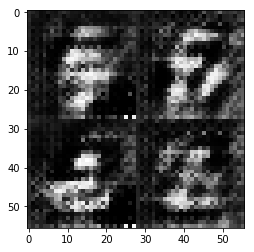

Epoch 1/2... Discriminator Loss: 2.2403... Generator Loss: 0.2570
Epoch 1/2... Discriminator Loss: 2.2216... Generator Loss: 0.1328
Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 1.0666
Epoch 1/2... Discriminator Loss: 0.2017... Generator Loss: 2.4107
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.6741


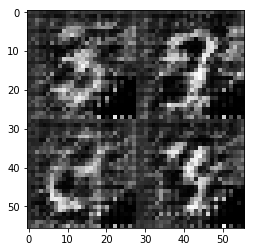

Epoch 1/2... Discriminator Loss: 2.3490... Generator Loss: 0.1393
Epoch 1/2... Discriminator Loss: 0.9378... Generator Loss: 0.8871
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 1.2667
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 0.5678... Generator Loss: 4.0317


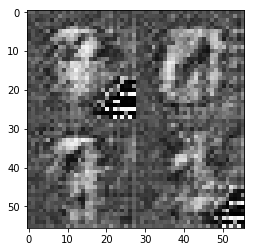

Epoch 1/2... Discriminator Loss: 0.0295... Generator Loss: 7.7849
Epoch 1/2... Discriminator Loss: 0.1329... Generator Loss: 4.8651
Epoch 1/2... Discriminator Loss: 0.0759... Generator Loss: 5.5820
Epoch 1/2... Discriminator Loss: 0.1119... Generator Loss: 8.9326
Epoch 1/2... Discriminator Loss: 0.4278... Generator Loss: 1.6217


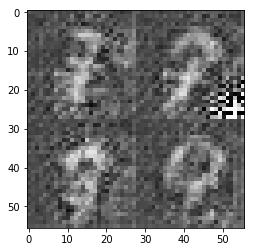

Epoch 1/2... Discriminator Loss: 0.0446... Generator Loss: 6.0406
Epoch 1/2... Discriminator Loss: 0.1399... Generator Loss: 3.2980
Epoch 1/2... Discriminator Loss: 0.3418... Generator Loss: 1.9334
Epoch 1/2... Discriminator Loss: 0.3289... Generator Loss: 1.9453
Epoch 1/2... Discriminator Loss: 0.6548... Generator Loss: 1.4090


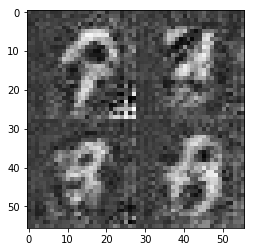

Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 2.3451
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.0865
Epoch 1/2... Discriminator Loss: 1.7603... Generator Loss: 0.2268
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.4724
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 0.6877


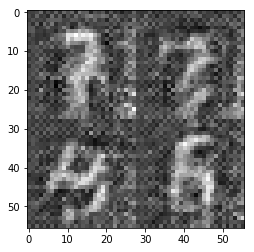

Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 1.1345
Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 1.5493
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.3624
Epoch 2/2... Discriminator Loss: 0.3189... Generator Loss: 2.1490
Epoch 2/2... Discriminator Loss: 0.5129... Generator Loss: 1.4183


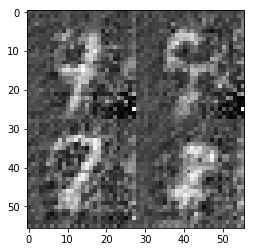

Epoch 2/2... Discriminator Loss: 0.4896... Generator Loss: 1.5333
Epoch 2/2... Discriminator Loss: 0.0945... Generator Loss: 4.4627
Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 1.4424
Epoch 2/2... Discriminator Loss: 3.0485... Generator Loss: 0.0938
Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 0.7314


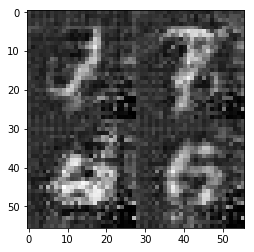

Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 1.2221
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 0.9006
Epoch 2/2... Discriminator Loss: 0.5343... Generator Loss: 1.3895
Epoch 2/2... Discriminator Loss: 0.4184... Generator Loss: 1.6983


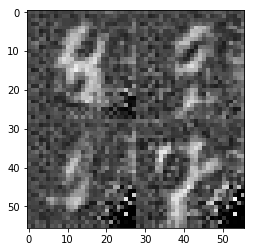

Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.4812
Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.1541
Epoch 2/2... Discriminator Loss: 0.0420... Generator Loss: 4.9241
Epoch 2/2... Discriminator Loss: 0.3897... Generator Loss: 1.5257
Epoch 2/2... Discriminator Loss: 0.0619... Generator Loss: 5.0246


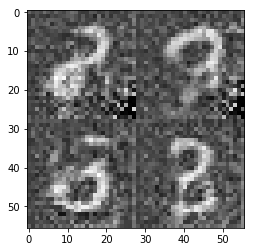

Epoch 2/2... Discriminator Loss: 0.4069... Generator Loss: 1.6962
Epoch 2/2... Discriminator Loss: 0.4959... Generator Loss: 9.0169
Epoch 2/2... Discriminator Loss: 1.5630... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 0.2744... Generator Loss: 2.3809
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 0.7157


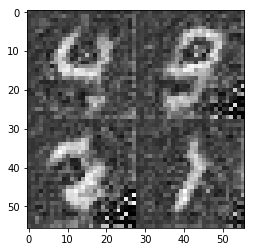

Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 0.9106
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 0.4867... Generator Loss: 3.0142
Epoch 2/2... Discriminator Loss: 0.4474... Generator Loss: 1.5079
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.5904


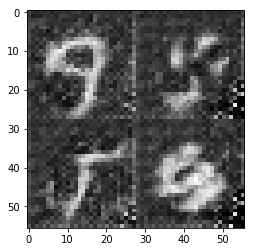

Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 0.6400
Epoch 2/2... Discriminator Loss: 0.8091... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 0.1959... Generator Loss: 4.0868
Epoch 2/2... Discriminator Loss: 0.0682... Generator Loss: 5.1642
Epoch 2/2... Discriminator Loss: 0.2078... Generator Loss: 2.7433


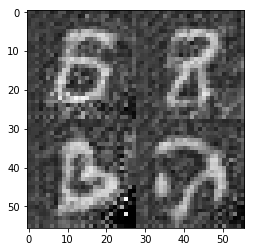

Epoch 2/2... Discriminator Loss: 0.1960... Generator Loss: 2.6665
Epoch 2/2... Discriminator Loss: 0.0799... Generator Loss: 3.9986
Epoch 2/2... Discriminator Loss: 0.2838... Generator Loss: 2.7536
Epoch 2/2... Discriminator Loss: 0.3340... Generator Loss: 1.9489
Epoch 2/2... Discriminator Loss: 0.1076... Generator Loss: 5.0432


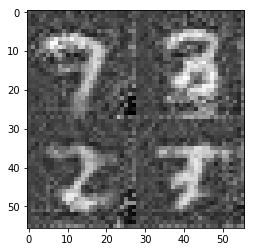

Epoch 2/2... Discriminator Loss: 0.0136... Generator Loss: 8.8560
Epoch 2/2... Discriminator Loss: 0.0832... Generator Loss: 3.5008
Epoch 2/2... Discriminator Loss: 0.1516... Generator Loss: 3.4824
Epoch 2/2... Discriminator Loss: 0.0210... Generator Loss: 7.2885
Epoch 2/2... Discriminator Loss: 0.0660... Generator Loss: 5.0761


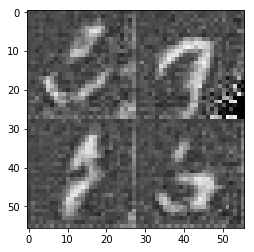

Epoch 2/2... Discriminator Loss: 0.0276... Generator Loss: 6.9999
Epoch 2/2... Discriminator Loss: 0.1886... Generator Loss: 3.4841
Epoch 2/2... Discriminator Loss: 0.1062... Generator Loss: 3.9344
Epoch 2/2... Discriminator Loss: 0.1410... Generator Loss: 2.6467
Epoch 2/2... Discriminator Loss: 0.2255... Generator Loss: 2.6389


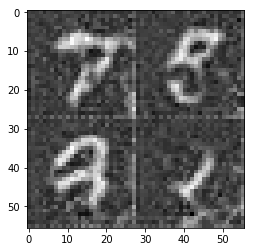

Epoch 2/2... Discriminator Loss: 0.1923... Generator Loss: 2.6048
Epoch 2/2... Discriminator Loss: 0.0845... Generator Loss: 4.0154
Epoch 2/2... Discriminator Loss: 0.1161... Generator Loss: 3.6829
Epoch 2/2... Discriminator Loss: 0.2189... Generator Loss: 2.5608
Epoch 2/2... Discriminator Loss: 0.2101... Generator Loss: 2.8857


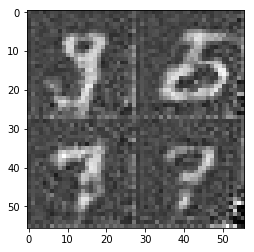

Epoch 2/2... Discriminator Loss: 0.0414... Generator Loss: 7.6161
Epoch 2/2... Discriminator Loss: 0.1373... Generator Loss: 5.1363
Epoch 2/2... Discriminator Loss: 0.1880... Generator Loss: 2.4495
Epoch 2/2... Discriminator Loss: 0.0353... Generator Loss: 7.0972
Epoch 2/2... Discriminator Loss: 1.5196... Generator Loss: 0.5642


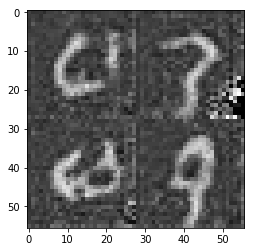

Epoch 2/2... Discriminator Loss: 1.5181... Generator Loss: 0.4010
Epoch 2/2... Discriminator Loss: 1.0803... Generator Loss: 0.5777
Epoch 2/2... Discriminator Loss: 0.9335... Generator Loss: 3.4298
Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 1.5284
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 0.7868


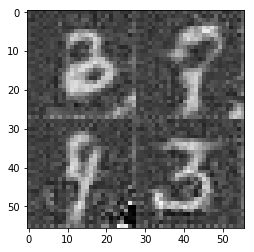

Epoch 2/2... Discriminator Loss: 0.5238... Generator Loss: 1.5072
Epoch 2/2... Discriminator Loss: 5.0005... Generator Loss: 0.0189
Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 2.9928
Epoch 2/2... Discriminator Loss: 0.5642... Generator Loss: 1.5660
Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 1.0194


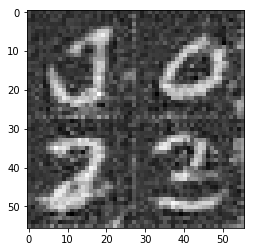

Epoch 2/2... Discriminator Loss: 0.6413... Generator Loss: 3.5605
Epoch 2/2... Discriminator Loss: 0.6785... Generator Loss: 1.1909
Epoch 2/2... Discriminator Loss: 0.4315... Generator Loss: 1.3830
Epoch 2/2... Discriminator Loss: 0.7424... Generator Loss: 1.0200
Epoch 2/2... Discriminator Loss: 1.1562... Generator Loss: 0.6742


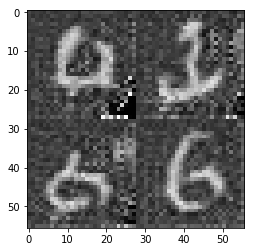

Epoch 2/2... Discriminator Loss: 0.2137... Generator Loss: 2.4797
Epoch 2/2... Discriminator Loss: 0.7326... Generator Loss: 0.8662
Epoch 2/2... Discriminator Loss: 0.1499... Generator Loss: 3.0199
Epoch 2/2... Discriminator Loss: 0.2645... Generator Loss: 2.1817
Epoch 2/2... Discriminator Loss: 0.0760... Generator Loss: 5.5509


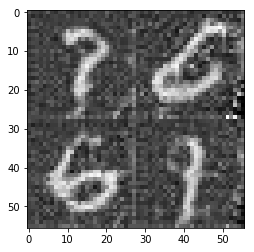

Epoch 2/2... Discriminator Loss: 0.0245... Generator Loss: 5.7385
Epoch 2/2... Discriminator Loss: 0.1458... Generator Loss: 2.9499
Epoch 2/2... Discriminator Loss: 0.0233... Generator Loss: 5.8977
Epoch 2/2... Discriminator Loss: 7.2149... Generator Loss: 0.0053
Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 1.2075


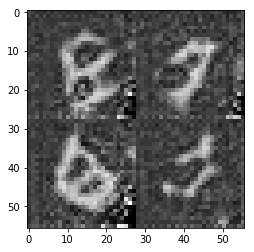

Epoch 2/2... Discriminator Loss: 0.4854... Generator Loss: 1.5193
Epoch 2/2... Discriminator Loss: 0.5578... Generator Loss: 1.3269
Epoch 2/2... Discriminator Loss: 0.3295... Generator Loss: 1.7813
Epoch 2/2... Discriminator Loss: 0.4855... Generator Loss: 1.4115
Epoch 2/2... Discriminator Loss: 0.9390... Generator Loss: 0.7296


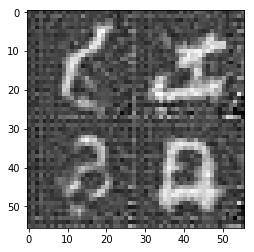

Epoch 2/2... Discriminator Loss: 0.1457... Generator Loss: 2.9442
Epoch 2/2... Discriminator Loss: 0.0318... Generator Loss: 5.8112


In [24]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.